<a href="https://colab.research.google.com/github/AksharJ47/regression-predict-api-template/blob/master/Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

![alt text](https://drive.google.com/uc?id=1sYROxQcqbjJCdH99lhywZn8juFKUrsN1)

Logistics in Sub-Saharan Africa increases the cost of manufactured goods by up to 320%; while in Europe, it only accounts for up to 90% of the manufacturing cost.

Economies are better when logistics is efficient and affordable.

This notebook aims to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

# Dependencies & Libraries

In [2]:
# Install dependencies

!pip install lightgbm
!pip install xgboost

In [1]:
# Import Libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
import seaborn as sns
from dateutil.parser import parse
import pickle

from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score,mean_absolute_error, mean_squared_error
from math import sqrt

# Data Pre-Processing


##### Prelimenary Exploration ( Shape , Features &  Missing-Data)

In [2]:
# Export and View Preview

train = pd.read_csv('https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Train_Zindi.csv')                
riders = pd.read_csv('https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Riders_Zindi.csv')   

print(train.head(3))
print(riders.head(3))

         Order No       User Id Vehicle Type  Platform Type  \
0   Order_No_4211   User_Id_633         Bike              3   
1  Order_No_25375  User_Id_2285         Bike              3   
2   Order_No_1899   User_Id_265         Bike              3   

  Personal or Business  Placement - Day of Month  \
0             Business                         9   
1             Personal                        12   
2             Business                        30   

   Placement - Weekday (Mo = 1) Placement - Time  Confirmation - Day of Month  \
0                             5       9:35:46 AM                            9   
1                             5      11:16:16 AM                           12   
2                             2      12:39:25 PM                           30   

   Confirmation - Weekday (Mo = 1)  ... Arrival at Destination - Time  \
0                                5  ...                   10:39:55 AM   
1                                5  ...                   12:17:22 

In [201]:
#  Train : Null-count and Shape 

print('Null count for each column :')                                           
print(train.isnull().sum())
print('The shape of the dataframe is' + ' ', train.shape)

Null count for each column :
Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Ar

In [3]:
# Riders : Null-count and Shape

print('Null count for each column :')                                           
print(riders.isnull().sum())
print('The shape of the dataframe is' + ' ', riders.shape)

Null count for each column :
Rider Id          0
No_Of_Orders      0
Age               0
Average_Rating    0
No_of_Ratings     0
dtype: int64
The shape of the dataframe is  (960, 5)


##### Feature Selection & Engineering

In [4]:
# Merge train and riders

data = pd.merge(train, riders, how='left', left_on='Rider Id',
                right_on='Rider Id', left_index=True)

In [5]:
# Populate Temperature and Precipitation Nulls

data['Precipitation in millimeters'] = data['Precipitation in millimeters'
                                           ].fillna(0)  

data['Temperature'] = data['Temperature'].fillna(data['Temperature'].mean()) 

In [6]:
# Drop Non-Numerical columns that cannot be One-Hot Encoded
# Drop Arrival information { Info not in the Test Dataframe }

data = data.drop(['Vehicle Type', 'User Id','Order No',
                 'Rider Id' ,'Arrival at Destination - Day of Month',
                 'Arrival at Destination - Weekday (Mo = 1)',
                 'Arrival at Destination - Time'],axis = 1)  

In [7]:
# Calculate Rating and Productivity of the riders

data['RatingFactor_Rider'] = data['Average_Rating']*data['No_of_Ratings']
data['Productivity_Rider'] = data['Age']/data['No_Of_Orders']

In [8]:
# Add column Separating 'Weekends' or 'Not Weekends' based on weekday data

def not_weekend(x):
    if x < 6:
        return 1
    else :
        return 0

data["not_weekend"] = data["Placement - Weekday (Mo = 1)"].apply(not_weekend)

In [9]:
# Separate Months into Four Quarters ( Form of Bagging )

def quarter_of_month(x):
    if x<=7:
        return 1
    elif x<=14:
        return 2
    elif x<=21:
        return 3
    else:
        return 4
    
data["Placement - Day of Month_quarter_of_month"] = data[
                          "Placement - Day of Month"].apply(quarter_of_month)

In [10]:
# Define Time manipulation functions

def time_parse_hr(time) :
    dt = parse(time)
    hour = dt.hour
    
    return hour

def time_parse_min(time) :
    dt = parse(time)
    minute = dt.minute
    
    return minute

def time_parse_sec(time) :
    dt = parse(time)
    second = dt.second
    
    return second

In [11]:
# Time manipulation application
# Separate time into respective Hour,Minute & Second

data['Placement - Hour'] = data['Placement - Time'].apply(time_parse_hr)
data['Placement - Minute'] = data['Placement - Time'].apply(time_parse_min)
data['Placement - Second'] = data['Placement - Time'].apply(time_parse_sec)
                                                            
data['Confirmation - Hour'] = data['Confirmation - Time'].apply(
                                                  time_parse_hr)
data['Confirmation - Minute'] = data['Confirmation - Time'].apply(
                                                    time_parse_min)
data['Confirmation - Second'] = data['Confirmation - Time'].apply(
                                                   time_parse_sec)

data['Arrival at Pickup - Hour'] = data['Arrival at Pickup - Time'].apply(
                                                               time_parse_hr)
data['Arrival at Pickup - Minute'] = data['Arrival at Pickup - Time'].apply(
                                                              time_parse_min)
data['Arrival at Pickup - Second'] = data['Arrival at Pickup - Time'].apply(
                                                              time_parse_sec)

data['Pickup - Hour'] = data['Pickup - Time'].apply(time_parse_hr)
data['Pickup - Minute'] = data['Pickup - Time'].apply(time_parse_min)
data['Pickup - Second'] = data['Pickup - Time'].apply(time_parse_sec)

In [12]:
# Drop the original times Features

data = data.drop(['Placement - Time' , 'Confirmation - Time',
                 'Arrival at Pickup - Time' ,'Pickup - Time' ],
                 axis = 1)

In [39]:
# One-Hot Encoding Catagorical data

new_data = pd.get_dummies(data, columns = ['Personal or Business'],drop_first = True)


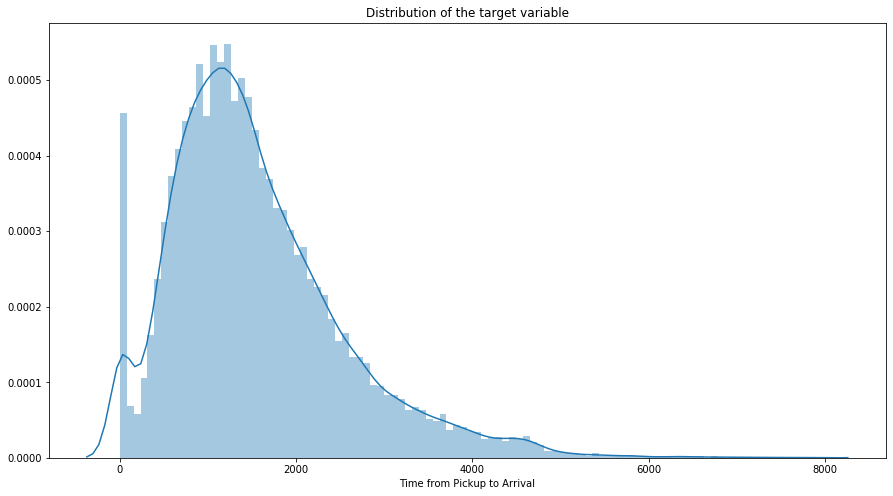

In [40]:
# Filter Riduculous Times ( e.g A delivery that took 1 sec )
# Check for Normal Distribution

plt.figure(figsize=(15,8))
plt.title('Distribution of the target variable')             

sns.distplot(new_data['Time from Pickup to Arrival'],
             bins=100,
             kde=True)

KEY NOTES



*   Distribution is Heavily Skewed to the Left
*   Lot of Outliars near Zero
*   Few Outliars above 5300





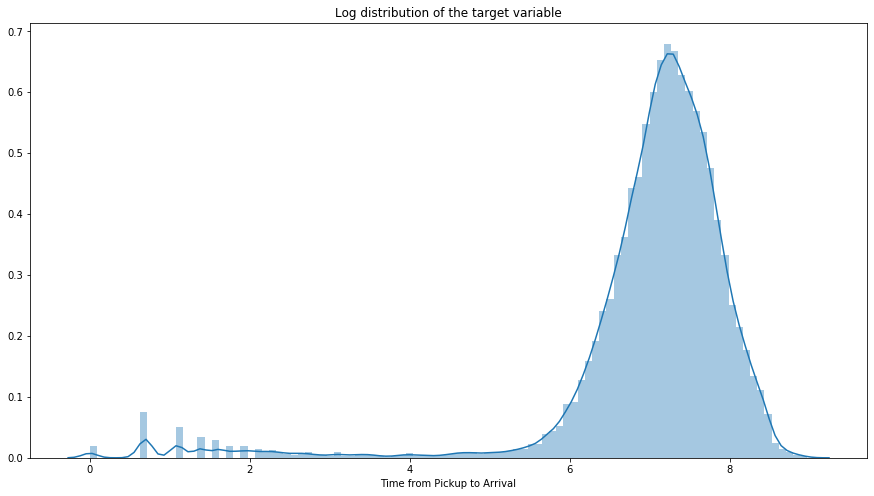

In [41]:
# Correcting for Skewness For Easy Filtering of points Near Zero

plt.figure(figsize=(15,8))                                       
plt.title('Log distribution of the target variable')             

sns.distplot(np.log(new_data['Time from Pickup to Arrival']),
             bins=100,
             kde=True)

Datapoints now follow a Normal Distribution

Outliars are now easily Visible


In [42]:
# Apply Filters based on the two above curves


# Log all values on the target variable
new_data['Time from Pickup to Arrival'] = np.log(new_data[
                                          'Time from Pickup to Arrival'])

# Filter Outliars based on the Log Curve
mod_data = new_data[new_data['Time from Pickup to Arrival'] > 5.1]

# Convert log values back linear form
mod_data['Time from Pickup to Arrival'] = np.exp(mod_data[
                                          'Time from Pickup to Arrival'])

# Filter the upper bound based on the Linear Curve
mod_data = mod_data[mod_data['Time from Pickup to Arrival'] < 5300 ]

C:\Users\Besodea\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [43]:
# Plot original dataset without outliars

plt.figure(figsize=(15,8))                                       
plt.title('Distribution of the target variable - Lower and Upper Outliers filtered')             

sns.distplot(mod_data['Time from Pickup to Arrival'],
             bins = 200,
             hist = False
             kde = True)

SyntaxError: invalid syntax (<ipython-input-43-abfbf0683939>, line 9)

Still Heavily Skewed , But there are No more outliars

##### Model Selection

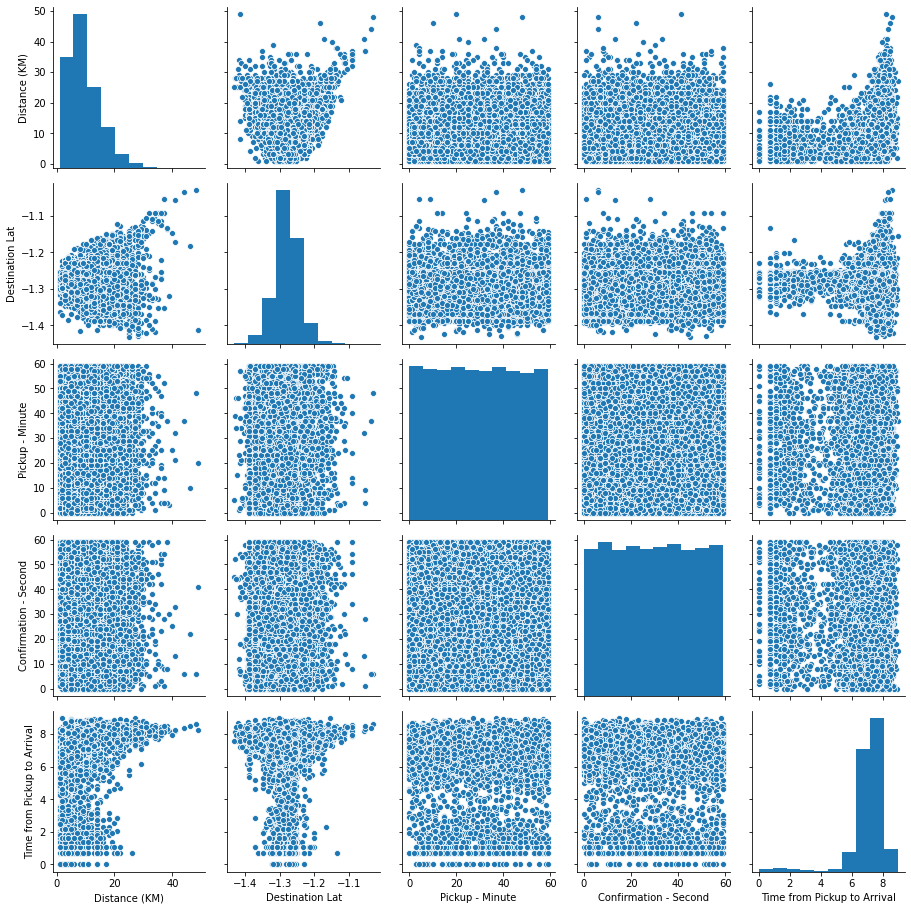

In [65]:
# See existing correlations among variables

batch_1 = new_data[['Distance (KM)','Destination Lat','Pickup - Minute',
                'Confirmation - Second','Time from Pickup to Arrival' ]]
sns.pairplot(batch_1)

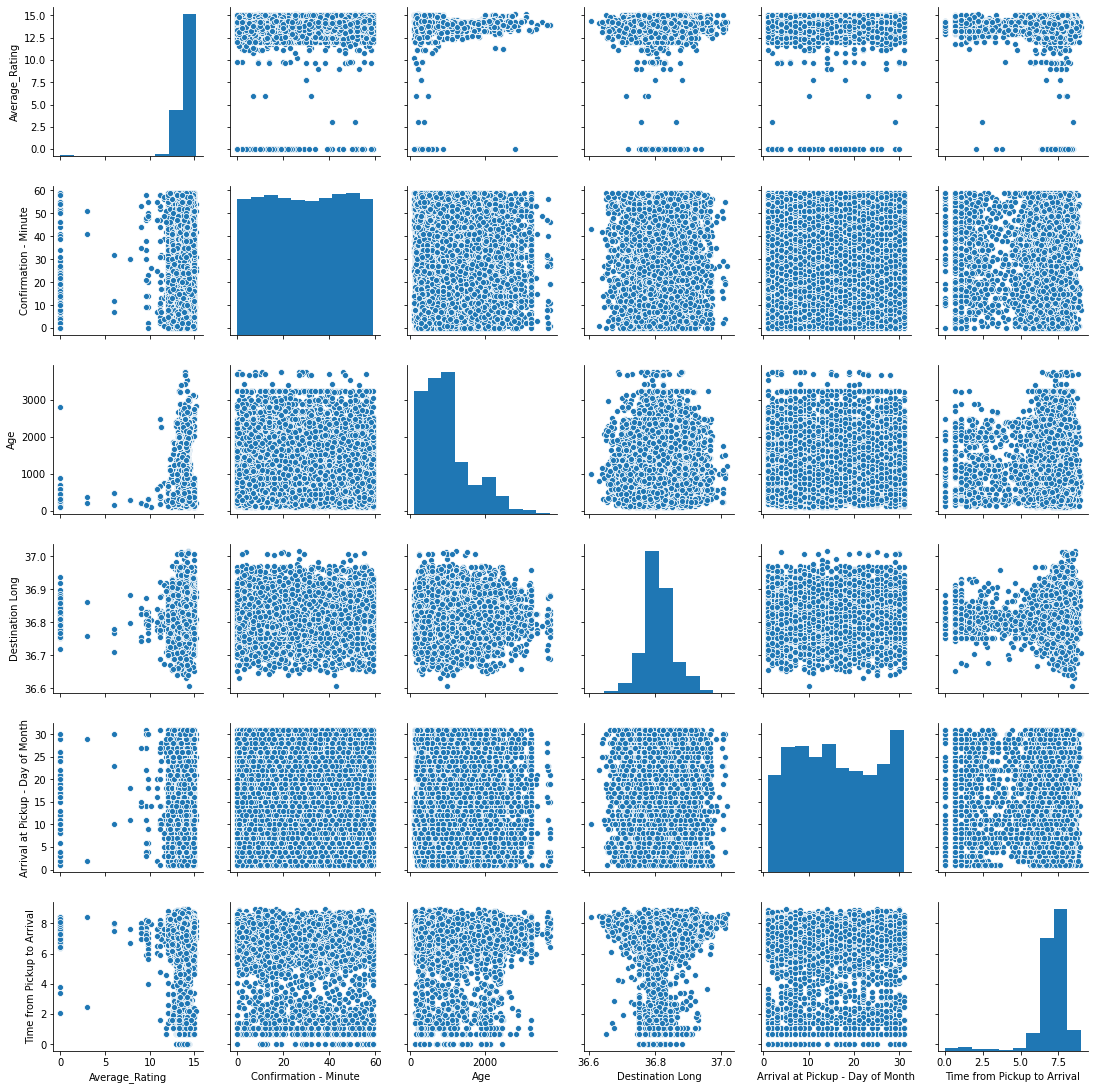

In [66]:
batch_2 = new_data[['Average_Rating','Confirmation - Minute',
                  'Age','Destination Long','Arrival at Pickup - Day of Month','Time from Pickup to Arrival' ]]
sns.pairplot(batch_2)

OBSERVATIONS

*   No feature is shows a linear correlation with the target
*   All features display complex relationships with the target
*   All features display complex relationships with other features

CONCLUSIONS

* A Tree Based model will perform better than any other function based model ( i.e Linear models , Polynomial models etc )



# Modelling

Tree-Based Models to be Cross Tested


*   DecisionTreeRegressor
*   RandomForestRegressor
*   XGBRegressor
*   LGBMRegressor



In [68]:
# Split the data into X & y 

X = mod_data.values
y = mod_data['Time from Pickup to Arrival'].astype(int)

print(X.shape)
print(y.shape)

(20241, 38)
(20241,)


In [59]:
column_order =['Distance (KM)',
  'Destination Lat',
  'Pickup - Minute',
  'Confirmation - Second',
  'Pickup Lat',
  'No_Of_Orders',
  'Productivity_Rider',
  'Pickup Long',
  'Placement - Second',
  'Pickup - Second',
  'Arrival at Pickup - Second',
  'Arrival at Pickup - Minute',
  'Placement - Minute',
  'Average_Rating',
  'Confirmation - Minute',
  'Age',
  'Destination Long',
  'Arrival at Pickup - Day of Month',
  'Pickup - Hour',
  'RatingFactor_Rider',
  'No_of_Ratings',
  'Pickup - Day of Month',
  'Temperature',
  'Confirmation - Hour',
  'Confirmation - Day of Month',
  'Pickup - Weekday (Mo = 1)',
  'Placement - Day of Month',
  'Placement - Hour',
  'Arrival at Pickup - Hour',
  'Confirmation - Weekday (Mo = 1)',
  'Placement - Weekday (Mo = 1)',
  'Placement - Day of Month_quarter_of_month',
  'Arrival at Pickup - Weekday (Mo = 1)',
#   'Personal or Business_Business',
  'Platform Type',
  'not_weekend',
  'Precipitation in millimeters',
  'Personal or Business_Personal']

In [70]:
# Create a train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                        train_size=0.80, test_size = 0.20, random_state=15)

In [71]:
# XGB
XGB = XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=4)
x = XGB.fit(X_train, y_train)

In [72]:
# LBG
LGB = LGBMRegressor(num_leaves = 30 ,random_state = 15 , learning_rate = 0.10 )
l = LGB.fit(X_train, y_train)

In [73]:
# Decision Tress
DCT = DecisionTreeRegressor(max_depth=5)
d = DCT.fit(X_train, y_train)

In [74]:
# Random Forests
RFG = RandomForestRegressor(n_estimators = 50,max_depth = 10)
r = RFG.fit(X_train, y_train)

In [75]:
# Accuracy test
all_models = {'XGBRegressor':x, 'LGBMRegressor':l ,
              'DecisionTreeRegressor':d,'RandomForestRegressor':r }

for i in all_models :
  print("")
  # The Root Mean Squared Error (RMSE)
  print(i)
  print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,all_models[i].predict(X_train))))
  print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test,all_models[i].predict(X_test))))
  print('The Accuracy R2  on the training dataset is: ',r2_score(y_train,all_models[i].predict(X_train)) )


XGBRegressor
The RMSE  on the training dataset is:  2.3364337885344093
The RMSE  on the testing dataset is:  2.6861565213976397
The Accuracy R2  on the training dataset is:  0.9999935799895353

LGBMRegressor
The RMSE  on the training dataset is:  6.52414237794203
The RMSE  on the testing dataset is:  10.21965256624412
The Accuracy R2  on the training dataset is:  0.9999499417526474

DecisionTreeRegressor
The RMSE  on the training dataset is:  38.06018904957339
The RMSE  on the testing dataset is:  37.33114724589442
The Accuracy R2  on the training dataset is:  0.9982963881123564

RandomForestRegressor
The RMSE  on the training dataset is:  0.5601007916308345
The RMSE  on the testing dataset is:  0.7296240731515804
The Accuracy R2  on the training dataset is:  0.9999996310554048


The best model is selected based on the following factors
in order of importance



*   Lowest RMSE on both Train and Test dataset ( Accuracy )
*   Smallest difference between Train RMSE and Test RMSE ( Overfitting/Underfitting)
*   Highest R-Squared ( Lowest Varience )


Based Upon the above criterior , **LGBMRegressor** is the best performer



Text(0.5, 1.0, 'Actuals Vs Residuals')

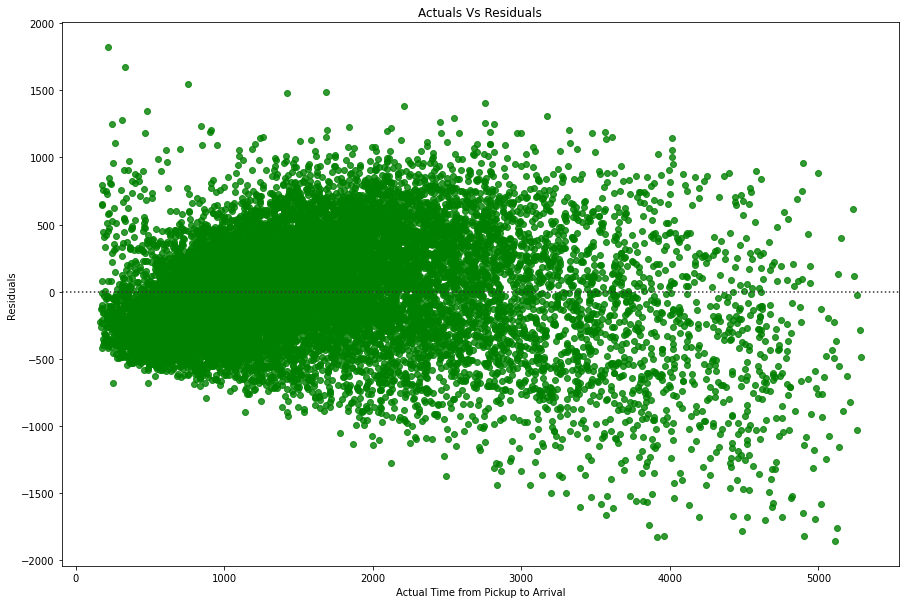

In [226]:
# Ploting Residuals for chosen model

plt.figure(figsize=(15,10))

sns.residplot(y_train, l.predict(X_train), color='green')
plt.xlabel('Actual Time from Pickup to Arrival')
plt.ylabel('Residuals')
plt.title('Actuals Vs Residuals')


# Preparing submission file 

In [0]:
# Exporting files

sub = pd.read_csv('https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Test_Zindi.csv')
sub_for_zindi = pd.read_csv('https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/SampleSubmission_Zindi.csv')

In [0]:
# Merge sub and riders

data_sub = pd.merge(sub, riders, how='left', left_on='Rider Id',
                    right_on='Rider Id', left_index=True)

In [0]:
# Populate Temperature and Precipitation

data_sub['Precipitation in millimeters'] = data_sub[
                                    'Precipitation in millimeters'].fillna(0)
                                      
data_sub['Temperature'] = data_sub['Temperature'].fillna(data_sub[
                                            'Temperature'].mean()) 

In [0]:
# Drop Non-Numerical columns that cannot be One-Hot Encoded

data_sub = data_sub.drop(['Vehicle Type', 'User Id','Order No',
                        'Rider Id'],axis = 1)

In [0]:
#  Riders Rating Factor and Productivity

data_sub['RatingFactor_Rider'] = data_sub['Average_Rating'
                                     ]*data_sub['No_of_Ratings']
                                     
data_sub['Productivity_Rider'] = data_sub['Age']/data_sub['No_Of_Orders']

In [0]:
# Add column Separating 'Weekends' or 'Not Weekends' based on weekday data

def not_weekend(x):
    if x < 6:
        return 1
    else :
        return 0

data_sub["not_weekend"] = data_sub["Placement - Weekday (Mo = 1)"].apply(
                                                              not_weekend)

In [0]:
# Separate Months into Four Quarters ( Form of Bagging )

def quarter_of_month(x):
    if x <= 7:
        return 1
    elif x <= 14:
        return 2
    elif x<=21:
        return 3
    else:
        return 4

data_sub["Placement - Day of Month_quarter_of_month"] = data_sub[
                          "Placement - Day of Month"].apply(quarter_of_month)

In [0]:
# Time manipulation application 

data_sub['Placement - Hour'] = data_sub['Placement - Time'].apply(time_parse_hr)
data_sub['Placement - Minute'] = data_sub['Placement - Time'].apply(
                                                      time_parse_min)
data_sub['Placement - Second'] = data_sub['Placement - Time'].apply(
                                                      time_parse_sec)
                                                            
data_sub['Confirmation - Hour'] = data_sub['Confirmation - Time'].apply(
                                                           time_parse_hr)
data_sub['Confirmation - Minute'] = data_sub['Confirmation - Time'].apply(
                                                           time_parse_min)
data_sub['Confirmation - Second'] = data_sub['Confirmation - Time'].apply(
                                                            time_parse_sec)

data_sub['Arrival at Pickup - Hour'] = data_sub[
                            'Arrival at Pickup - Time'].apply(time_parse_hr)
data_sub['Arrival at Pickup - Minute'] = data_sub[
                            'Arrival at Pickup - Time'].apply(time_parse_min)
data_sub['Arrival at Pickup - Second'] = data_sub[
                          'Arrival at Pickup - Time'].apply(time_parse_sec)

data_sub['Pickup - Hour'] = data_sub['Pickup - Time'].apply(time_parse_hr)
data_sub['Pickup - Minute'] = data_sub['Pickup - Time'].apply(time_parse_min)
data_sub['Pickup - Second'] = data_sub['Pickup - Time'].apply(time_parse_sec)

In [0]:
# Drop original times plus more columns

data_sub = data_sub.drop(['Placement - Time' , 'Confirmation - Time',
                 'Arrival at Pickup - Time' ,'Pickup - Time'],
                 axis = 1)

In [0]:
# One-Hot Encoding

data_sub = pd.get_dummies(data_sub, columns = ['Personal or Business'])

In [0]:
# Same order as used in training

data_sub = data_sub[column_order]     

In [238]:
# Same Number of Features as used in training

data_sub.shape

(7068, 38)

In [0]:
# Define Features

X_sub = data_sub.values

In [0]:
# Make prediction

y_sub = l.predict(X_sub)

In [0]:
# Create dictionary for mapping

order_no = np.array(sub['Order No'])
sub_dict = day_dict = dict(zip(order_no, y_sub))

In [0]:
# Map dictionary

sub_for_zindi['Time from Pickup to Arrival'] = sub_for_zindi['Order_No'].map(
                                                                    sub_dict)

In [243]:
sub_for_zindi

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,1614.526530
1,Order_No_12736,1365.691634
2,Order_No_768,1342.539683
3,Order_No_15332,1112.748763
4,Order_No_21373,1141.494759
...,...,...
7063,Order_No_3612,1646.450768
7064,Order_No_7657,2890.125302
7065,Order_No_1969,1723.091009
7066,Order_No_10591,2535.929059


In [0]:
# Save as a CSV file

sub_for_zindi.to_csv('Submission_file_v_17.csv' , index = False)

# Relavant Insights

### 1. Customer Trends

In [96]:
mod_data.head().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 27 to 159
Data columns (total 38 columns):
Platform Type                                5 non-null int64
Placement - Day of Month                     5 non-null int64
Placement - Weekday (Mo = 1)                 5 non-null int64
Confirmation - Day of Month                  5 non-null int64
Confirmation - Weekday (Mo = 1)              5 non-null int64
Arrival at Pickup - Day of Month             5 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         5 non-null int64
Pickup - Day of Month                        5 non-null int64
Pickup - Weekday (Mo = 1)                    5 non-null int64
Distance (KM)                                5 non-null int64
Temperature                                  5 non-null float64
Precipitation in millimeters                 5 non-null float64
Pickup Lat                                   5 non-null float64
Pickup Long                                  5 non-null float64
Destination Lat     

Text(0, 0.5, 'No. od orders')

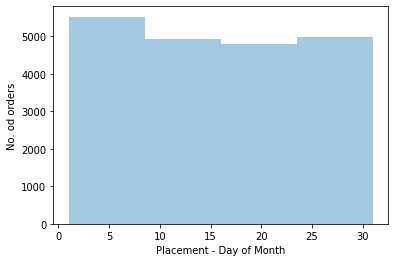

In [124]:
sns.distplot(mod_data['Placement - Day of Month'], kde = False,bins = 4)
plt.ylabel('No. od orders')

TypeError: 'str' object is not callable

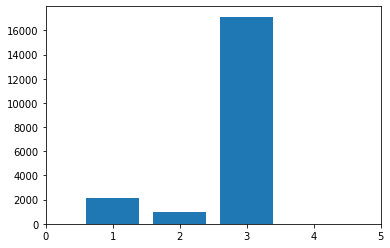

In [121]:
platform_types = mod_data['Platform Type'].value_counts()
plt.bar(platform_types.index,platform_types)
plt.xlim(0, 5)
plt.xlabel('Platform_type')
plt.ylabel('Number of orders')
plt.xticks(np.arange(0, 5, step=1))
# plt.axe

<function matplotlib.pyplot.show(*args, **kw)>

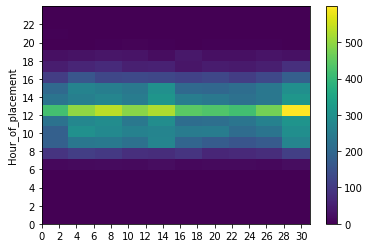

In [116]:
plt.hist2d(x = mod_data['Placement - Day of Month'],y = mod_data['Placement - Hour'],bins=(10,20),\
          range=((0,31),(0,24)))
plt.xlabel('Day_of_placement')
plt.ylabel('Hour_of_placement')
plt.xticks(np.arange(0, 31, step=2))
plt.yticks(np.arange(0, 24, step=2))
plt.colorbar()
plt.show

Most Orders are placed on the first quarter of the month with most orders happening between hours of 12 PM and 2 PM(top graph and the 2D histogram convey this information), on an hourly basis most orders are recieved on the last 2 days of the month between 12 PM and 2 PM.
The majority of customers use Platform type 3 for their packages.